In [21]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
from scipy import stats

In [2]:
# loading in data
df = pd.read_parquet('final_df.parquet')

# inspecting data
df.head()

,Size,Open Viewing,Lot,Bathrooms,Time,Postcode,Heating,Status,Bedrooms,Rates,Receptions,Broadband,Price (£),Venue,Postcode_number,Address,Style,Estate Agent,Belfast District
0,None,None,None,2,None,BT8 8FX,None,None,4,1652.05,2,900Mbps,335000.0,None,BT8,5 Haddo Crescent,Townhouse,Ulster Property Sales (Forestside),South
1,None,None,None,1,None,BT7 3DQ,Gas,None,1,826.03,1,900Mbps,129950.0,None,BT7,5 Annadale Green,Apartment,Nicholas Residential,South
2,None,None,None,2,None,BT8 6GY,Gas,For sale,4,1296.73,1,900Mbps,239950.0,None,BT8,11 Finsbury Drive,Semi-detached House,James Duggan Estates,South
3,None,None,None,None,None,BT7 3JH,Gas,None,3,1391.20,1,80Mbps,219950.0,None,BT7,"Apt 13 Anna Hill, 2 Annadale Avenue",Apartment,Templeton Robinson (Lisburn Road),South
4,None,None,None,4,None,BT8 8LN,None,None,6,None,3,None,675000.0,None,BT8,103 Fort Road,Detached House,Fetherstons (South Belfast Office),South


In [3]:
df.loc[df['Address'].str.contains('Hamptons')]

,Size,Open Viewing,Lot,Bathrooms,Time,Postcode,Heating,Status,Bedrooms,Rates,Receptions,Broadband,Price (£),Venue,Postcode_number,Address,Style,Estate Agent,Belfast District
37,None,None,None,2,None,Belfast,Gas,For sale,4,None,2,None,865000.0,None,Belfast,"The Deane (site 18), The Hamptons",Detached House,GOC Estate Agents,None
175,None,None,None,2,None,Belfast,Gas,For sale,4,None,2,None,865000.0,None,Belfast,"The Heath (site 32), The Hamptons",Detached House,GOC Estate Agents,None
296,None,None,None,2,None,Belfast,Gas,For sale,4,None,2,None,835000.0,None,Belfast,"The Heath (site 10), The Hamptons",Detached House,GOC Estate Agents,None
368,None,None,None,2,None,Belfast,Gas,For sale,4,None,2,None,1100000.0,None,Belfast,"The Satchwell (site 9), The Hamptons",Detached House,GOC Estate Agents,None
453,None,None,None,2,None,Belfast,Gas,For sale,4,None,2,None,1100000.0,None,Belfast,"The Satchwell (site 8), The Hamptons",Detached House,GOC Estate Agents,None
515,None,None,None,3,None,Belfast,Gas,For sale,4,None,2,None,835000.0,None,Belfast,"The Deane (site 3a), The Hamptons",Detached House,GOC Estate Agents,None
560,None,None,None,3,None,Belfast,Gas,For sale,4,None,2,None,835000.0,None,Belfast,"The Deane (site 3), The Hamptons",Detached House,GOC Estate Agents,None
625,"2,316 sq. feet",None,None,2,None,Belfast,Gas,For sale,4,None,2,None,NaN,None,Belfast,"The Chatham (site 4c), The Hamptons",Detached House,GOC Estate Agents,None


# After initial inspection we can see that there are several columns that will not add anything to our analysis so we will get rid of them. Additionally, there are columns where the values will need to be cleaned and null values addressed.

In [4]:
# Dropping columns we don't need
df = df.drop(columns=['Size', 'Open Viewing', 'Lot', 'Time', 'Status', 'Venue', 'Heating', 'Broadband'])

# Removing the leading white space from the Postcode column
df['Postcode'] = df['Postcode'].apply(lambda x: x.lstrip() if pd.notna(x) else x)

# It appears we have pulled in 'Belfast' in the postcode column, which clearly shouldn't be there. Rather than discarding these values I can see that the vast majority are in 'The Hamptons' and the 'Orchard Hall Apartments' thus I should be able to find a postcode for these properties and update the dataset.

In [5]:
df['Postcode_number'] = np.where(df['Address'].str.contains('The Hamptons'), 'BT7', df['Postcode_number'])
df['Postcode_number'] = np.where(df['Address'].str.contains('Orchard Hall'), 'BT4', df['Postcode_number'])
df['Postcode_number'] = np.where(df['Address'].str.contains('The Admin Building'), 'BT8', df['Postcode_number'])
df['Postcode_number'] = np.where(df['Address'].str.contains('Lesley Park Demesne'), 'BT9', df['Postcode_number'])

In [6]:
# Now we will check to see how many postcodes say 'Belfast'
df.loc[df['Postcode_number'] == 'Belfast']

,Bathrooms,Postcode,Bedrooms,Rates,Receptions,Price (£),Postcode_number,Address,Style,Estate Agent,Belfast District
16,3,Belfast,5,None,2,499950.0,Belfast,"The Bracken, Ferndene",Detached House,Simon Brien Residential (East Belfast),None
585,None,Belfast,4,None,1,NaN,Belfast,"The Willow, House Type S, Castlehill Wood",Semi-detached House,Simon Brien Residential (East Belfast),None
603,2,Belfast,4,None,2,695000.0,Belfast,"Phase 2, Madigan Hill",Detached House,Marketed by multiple agents,None
617,2,Belfast City Centre,2,None,1,225000.0,Belfast,"Two Bedrooms, Coyles Place At Portland 88",Apartments,Colliers New Homes,None
889,3,Belfast,4,None,2,565000.0,Belfast,"The Pottinger, Baron Lane",Detached House,Colliers New Homes,None
932,1,Belfast City Centre,1,None,1,165000.0,Belfast,"One Bedroom, Coyles Place At Portland 88",Apartment,Colliers New Homes,None
1023,2,Belfast,2,None,1,NaN,Belfast,"2 Bedroom Apartment, 100 Kings Road",Apartment,Marketed by multiple agents,None


# It would be possible to get a postcode for the remaining 7 properties by searching each individual address, instead, in the interest of time we will remove these properties from the dataset.

# It would be interesting to compare how each estate agent is performing amongst one another so I will remove the office in parentheses.

In [7]:
# Function to remove parentheses from estate agent
def remove_parentheses(row):
    return re.sub(r'\([^)]*\)', '', row)

df['Estate Agent'] = df['Estate Agent'].apply(lambda x: remove_parentheses(x) if pd.notna(x) else x)

In [8]:
# Inspecting different property styles
df['Style'].unique()

array(['Townhouse', 'Apartment', 'Semi-detached House', 'Detached House',
       'Terrace House', 'Semi-detached Bungalow', 'End Townhouse',
       'Mid-terrace House', '3rd Floor Apartment', 'Detached Villa',
       'End-terrace House', 'House', 'Detached Bungalow',
       'Ground Floor Apartment', 'Mid Townhouse', 'Apartments',
       'Extended Mid-terrace', 'Semi-detached Villa', 'Duplex Apartment',
       'Penthouse Apartment', '1st Floor Apartment', 'Ground Floor Flat',
       'Detached Chalet', 'Apartment / Flat', 'Bungalow',
       '2nd Floor Apartment', 'Semi-detached Chalet',
       'Link-detached house', 'Detached Duplex Bungalow',
       'Detached with annex', 'Detached Chalet Bungalow',
       'House and Land', 'Semi-detached Chalet Bungalow', 'Duplex Flat',
       'Flat'], dtype=object)

# After inspection, we can see that there are 35 different property styles in the dataset, this is far too many. For the sake of our analysis we would like to get this number down as a low as possible. To do this we will use the replace method available on strings to search for certain key words, for example the first line of code that follows searches for anything that starts or ends with the words 'flat' or 'apartment' and converts the value to just say 'Apartment'. This allows each style to be correctly grouped together within one style rather than existing across multiple styles for the sake of a few words. A similar approach is taken to other styles including: Detached, Semi-detached, Townhouse, Bungalow and Terrace.

In [9]:
# Cleaning up styles
df['Style'] = df['Style'].str.replace(r'.*(flat|apartment).*', 'Apartment', case=False, regex=True)
df['Style'] = df['Style'].str.replace(r'.*(link|semi-detached).*', 'Semi-detached House', case=False, regex=True)
df['Style'] = df['Style'].str.replace(r'.*(terrace).*', 'Terrace House', case=False, regex=True)
df['Style'] = df['Style'].str.replace(r'.*(townhouse).*', 'Townhouse', case=False, regex=True)
df['Style'] = df['Style'].str.replace(r'.*(bungalow).*', 'Bungalow', case=False, regex=True)
df['Style'] = df['Style'].apply(lambda x: x.replace(x, 'Detached House') if x in ['Detached Villa', 'Detached Chalet', 'Detached with annex'] else x)

# Finally because 'House' and 'House and Land' don't add to our analysis we will remove them from the dataset.
styles_to_remove = ['House','House and Land']
df = df[~df['Style'].isin(styles_to_remove)]

In [10]:
df['Style'].unique()

array(['Townhouse', 'Apartment', 'Semi-detached House', 'Detached House',
       'Terrace House', 'Bungalow'], dtype=object)

# We now have a manageable number of property styles that we will use in our subsequent analysis.

# The next stage is to investigate the Price column to see if we have any outliers that need addressed. Upon inspection there are a few outliers contained with this data, however, given the nature of this analysis I have chosen to only use a 10% - 90% quantile range as it is natural to expect higher and lower property values within certain postcode areas. Important to note that each quantile range is a reflection of the postcode number and style of property.

In [11]:
# Remove Outliers
# Calculate the IQR for each unique postcode
iqr_per_postcode = pd.DataFrame(df.groupby(['Postcode_number','Style'])['Price (£)'].quantile([0.1, 0.9]).unstack()).reset_index()
iqr_per_postcode.columns = ['Postcode_number','Style', 'Q1', 'Q3']
iqr_per_postcode

,Postcode_number,Style,Q1,Q3
0,BT1,Apartment,122500.0,407475.0
1,BT10,Apartment,132980.0,204980.0
2,BT10,Bungalow,325000.0,325000.0
3,BT10,Detached House,260985.0,324985.0
4,BT10,Semi-detached House,180980.0,290980.0
...,...,...,...,...
79,BT9,Townhouse,168000.0,557000.0
80,Belfast,Apartment,171000.0,219000.0
81,Belfast,Detached House,512960.0,669000.0
82,Belfast,Semi-detached House,NaN,NaN


In [12]:
# Merge the IQR values back into the original DataFrame
df = df.merge(iqr_per_postcode, on=['Postcode_number','Style'])
# Filter the rows based on the IQR values
df = df[(df['Price (£)'] >= df['Q1']) & (df['Price (£)'] <= df['Q3'])]

# Drop the 10% and 90% quantile columns
df.drop(columns=['Q1','Q3'], inplace=True)

# The next stage is to deal with the null Rates values. I have decided to use the average rates for each property style within a postcode number. This ensures, for example, an apartment within BT4 gets a rates value that reflects another apartment in BT4 rather than a rates value that is distorted by a detached home in BT9.

In [13]:
# Updating null rates values
df['Rates'] = pd.to_numeric(df['Rates'], errors='coerce')
avg_rates_by_group = df.groupby(['Postcode_number','Style'])['Rates'].mean().round(0)

# Merge the average rates with the original DataFrame
df = df.merge(avg_rates_by_group, on=['Postcode_number', 'Style'], how='left', suffixes=('', '_avg'))

# Fill null values with the corresponding average rate
df['Rates'].fillna(df['Rates_avg'], inplace=True)
df.drop(columns=['Rates_avg'], inplace=True)


# The final bit of data cleansing we need to do is addressing the null bathrooms and receptions. Having looked at the data, its safe to assume that every detached and semi-detached has at least 1 reception and 1 bathroom, for any property that has 2 receptions it is likely that they also have 2 bathrooms.

In [14]:
df.loc[(df['Receptions'] == '1') | (df['Receptions'].isna()) & (df['Bathrooms'].isna()), 'Bathrooms'] = '1'

In [15]:
df.loc[(df['Receptions'] == '2') & (df['Bathrooms'].isna()) & (df['Style'] != 'Apartment'), 'Bathrooms'] = '2'

In [16]:
# Assuming every house style has at least 1 reception and 1 bathroom
df.loc[df['Receptions'].isna(), 'Receptions'] = '1'
df.loc[df['Bathrooms'].isna(), 'Bathrooms'] = '1'

In [17]:
df.loc[df['Rates'].isna()] ### Need to fix this

,Bathrooms,Postcode,Bedrooms,Rates,Receptions,Price (£),Postcode_number,Address,Style,Estate Agent,Belfast District
275,3,Belfast,4,NaN,2,565000.0,Belfast,"The Pottinger, Baron Lane",Detached House,Colliers New Homes,None
357,2,Belfast,4,NaN,2,865000.0,BT7,"The Deane (site 18), The Hamptons",Detached House,GOC Estate Agents,None
358,2,Belfast,4,NaN,2,865000.0,BT7,"The Heath (site 32), The Hamptons",Detached House,GOC Estate Agents,None
359,2,Belfast,4,NaN,2,835000.0,BT7,"The Heath (site 10), The Hamptons",Detached House,GOC Estate Agents,None
360,2,Belfast,4,NaN,2,1100000.0,BT7,"The Satchwell (site 9), The Hamptons",Detached House,GOC Estate Agents,None
361,2,Belfast,4,NaN,2,1100000.0,BT7,"The Satchwell (site 8), The Hamptons",Detached House,GOC Estate Agents,None
362,3,Belfast,4,NaN,2,835000.0,BT7,"The Deane (site 3a), The Hamptons",Detached House,GOC Estate Agents,None
363,3,Belfast,4,NaN,2,835000.0,BT7,"The Deane (site 3), The Hamptons",Detached House,GOC Estate Agents,None
676,1,BT12 5GF,2,NaN,1,165000.0,BT12,Apartment 58 Victoria Place,Apartment,CPS,West


In [18]:
avg_rates_by_group

Postcode_number  Style              
BT1              Apartment              1174.0
BT10             Apartment              1000.0
                 Bungalow               1652.0
                 Detached House         1913.0
                 Semi-detached House    1313.0
                                         ...  
BT9              Detached House         3397.0
                 Semi-detached House    3000.0
                 Terrace House          1251.0
                 Townhouse              2269.0
Belfast          Detached House            NaN
Name: Rates, Length: 78, dtype: float64

#                                                                    ANALYSIS











In [19]:
df

,Bathrooms,Postcode,Bedrooms,Rates,Receptions,Price (£),Postcode_number,Address,Style,Estate Agent,Belfast District
0,2,BT8 8FX,4,1652.05,2,335000.0,BT8,5 Haddo Crescent,Townhouse,Ulster Property Sales,South
1,1,BT8 8GU,3,1129.41,1,229950.0,BT8,84 The Demesne,Townhouse,Ulster Property Sales,South
2,2,BT8 8FX,4,1652.05,2,335000.0,BT8,5 Haddo Crescent,Townhouse,Ulster Property Sales,South
3,1,BT8 7YG,2,1045.75,1,169000.0,BT8,17 Greer Park Heights,Townhouse,Fetherstons,South
4,1,BT8 6BA,4,1882.35,1,245000.0,BT8,5 Croft Hill Cottages,Townhouse,Ulster Property Sales,South
...,...,...,...,...,...,...,...,...,...,...,...
772,1,BT36 7EY,2,586.91,2,79950.0,BT36,17 Voltaire Gardens,Semi-detached House,Pinpoint Property,None
773,1,BT14 6LF,4,630.39,2,119950.0,BT14,19 Clifton Crescent,Townhouse,House To Home Estate Agents,North-West
774,1,BT11 9QW,2,652.13,1,129950.0,BT11,10 Gweedore Crescent,Townhouse,Ulster Property Sales,West
775,3,BT17 0JE,5,3043.25,3,399950.0,BT17,11 Glengoland Gardens,Bungalow,Ulster Property Sales,South/South-West


In [21]:
# Enrich data by bringing in the Longitude and Latitude

In [22]:
# Final number of properties
len(df)

777

In [23]:
# Breakdown of each style
df['Style'].value_counts()

Style
Terrace House          222
Semi-detached House    208
Apartment              160
Detached House         138
Townhouse               35
Bungalow                14
Name: count, dtype: int64

In [ ]:
# Bringing in longitude and latitude data

In [34]:
lon_lat_df = pd.read_csv('ni_postcodes.csv')

In [35]:
lon_lat_df = lon_lat_df.iloc[:,2:]

In [36]:
lon_lat_df

,postcode,latitude,longitude
0,BT70 3NY,54.512217,-6.831684
1,BT4 1PW,54.602653,-5.878404
2,BT9 5PG,54.552294,-5.969607
3,BT39 9TS,54.777369,-5.952764
4,BT5 6ED,54.591760,-5.871559
...,...,...,...
49938,BT79 7ZJ,54.717834,-7.150987
49939,BT8 8SJ,54.508324,-5.897766
49940,BT8 8SL,54.508324,-5.897766
49941,BT80 8FU,54.653950,-6.745192


In [37]:
df

,Bathrooms,Postcode,Bedrooms,Rates,Receptions,Price (£),Postcode_number,Address,Style,Estate Agent,Belfast District
0,2,BT8 8FX,4,1652.05,2,335000.0,BT8,5 Haddo Crescent,Townhouse,Ulster Property Sales,South
1,1,BT8 8GU,3,1129.41,1,229950.0,BT8,84 The Demesne,Townhouse,Ulster Property Sales,South
2,2,BT8 8FX,4,1652.05,2,335000.0,BT8,5 Haddo Crescent,Townhouse,Ulster Property Sales,South
3,1,BT8 7YG,2,1045.75,1,169000.0,BT8,17 Greer Park Heights,Townhouse,Fetherstons,South
4,1,BT8 6BA,4,1882.35,1,245000.0,BT8,5 Croft Hill Cottages,Townhouse,Ulster Property Sales,South
...,...,...,...,...,...,...,...,...,...,...,...
772,1,BT36 7EY,2,586.91,2,79950.0,BT36,17 Voltaire Gardens,Semi-detached House,Pinpoint Property,None
773,1,BT14 6LF,4,630.39,2,119950.0,BT14,19 Clifton Crescent,Townhouse,House To Home Estate Agents,North-West
774,1,BT11 9QW,2,652.13,1,129950.0,BT11,10 Gweedore Crescent,Townhouse,Ulster Property Sales,West
775,3,BT17 0JE,5,3043.25,3,399950.0,BT17,11 Glengoland Gardens,Bungalow,Ulster Property Sales,South/South-West


In [38]:
merged_df = pd.merge(df,
                     lon_lat_df,
                     left_on='Postcode',
                     right_on='postcode',
                     how='inner')

In [52]:
merged_df['Bedrooms'] = pd.to_numeric(df['Bedrooms'], errors='coerce')
merged_df.drop(columns={'postcode'}, inplace=True)

In [79]:
merged_df.to_csv('merged_df.csv')

In [42]:
# Breakdown of each style
merged_df['Style'].value_counts()

Style
Terrace House          222
Semi-detached House    208
Apartment              146
Detached House         126
Townhouse               35
Bungalow                14
Name: count, dtype: int64

# We can see that Terrace and Semi-Detached Houses are the two most popular property types in our dataset. Starting with the Terrace house we will investigate what's on offer across the different Belfast districts and what we can expect price wise.

In [60]:
terrace_df = merged_df.loc[merged_df['Style'] == 'Terrace House']

In [61]:
terrace_df

,Bathrooms,Postcode,Bedrooms,Rates,Receptions,Price (£),Postcode_number,Address,Style,Estate Agent,Belfast District,postcode,latitude,longitude
149,1,BT9 7FH,2.0,1304.25,1,165000.0,BT9,34 Windsor Drive,Terrace House,360 Residential Ltd,South,BT9 7FH,54.581070,-5.951873
150,1,BT9 7FH,2.0,1130.35,2,150000.0,BT9,17 Windsor Drive,Terrace House,McGeown Estate Agents,South,BT9 7FH,54.581070,-5.951873
173,1,BT12 7PL,3.0,717.34,1,104950.0,BT12,35 Brittons Drive,Terrace House,NorthernProperty.com,West,BT12 7PL,54.592821,-5.974213
174,1,BT12 7LX,3.0,739.08,1,99950.0,BT12,66 Beechmount Parade,Terrace House,NorthernProperty.com,West,BT12 7LX,54.592948,-5.966780
175,1,BT12 4AG,3.0,717.34,1,114950.0,BT12,43 John Street,Terrace House,NorthernProperty.com,West,BT12 4AG,54.598849,-5.937439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,1,BT11 9AQ,3.0,695.60,1,119950.0,BT11,181 Stockmans Lane,Terrace House,NorthernProperty.com,West,BT11 9AQ,54.574049,-5.979939
735,1,BT11 9AQ,3.0,695.60,1,129950.0,BT11,179 Stockmans Lane,Terrace House,Ulster Property Sales,West,BT11 9AQ,54.574049,-5.979939
736,1,BT11 8NB,2.0,782.55,1,169950.0,BT11,19 Tullagh Park,Terrace House,Ulster Property Sales,West,BT11 8NB,54.577411,-6.003886
737,1,BT11 8QU,2.0,1086.88,1,179950.0,BT11,6 Airfield Heights,Terrace House,McGranaghan Estate Agents.com,West,BT11 8QU,54.581533,-5.998629


In [75]:
terrace_analysis_df = terrace_df.groupby('Belfast District').agg({
    'Bedrooms': 'mean',
    'Price (£)': 'mean',
    'Rates': 'mean',
    'Address': 'count'
}).round(1)

terrace_analysis_df.rename(columns={'Address':'No. of Houses'}, inplace=True)
terrace_analysis_df

,Bedrooms,Price (£),Rates,No. of Houses
Belfast District,,,,
East,2.8,121214.2,698.9,53
North,4.1,129623.4,609.5,32
North-West,2.8,110187.9,607.5,29
South,2.6,165095.7,1164.2,47
South-East,2.6,124261.1,736.7,18
South/South-West,3.4,125870.0,687.1,10
West,2.8,113954.5,725.6,33


# Based on these results we can see that Terrace houses in North Belfast have the highest average number of bedrooms, South Belfast has both the highest average price and average Rates. I also included the number of houses within each district to ensure the data wasn't bias. Lets move on to look at the different detached homes in Belfast.

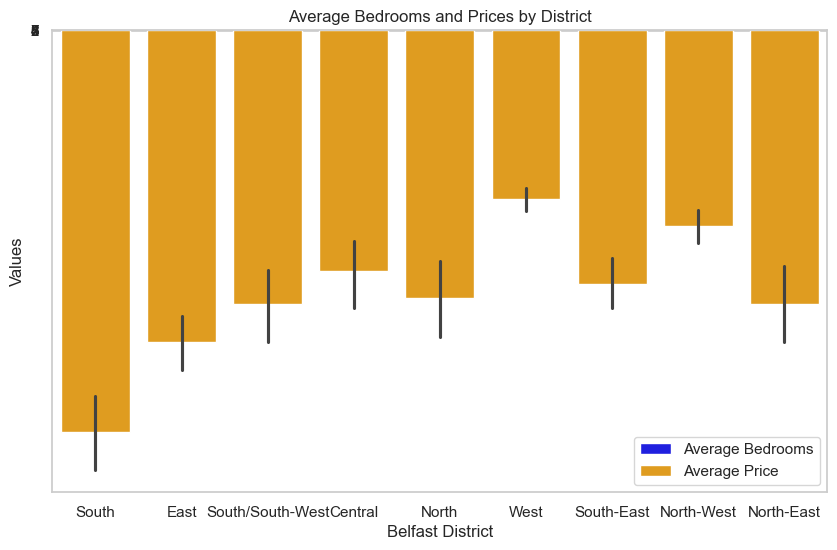

In [78]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Belfast District', y='Bedrooms', data=df, color='blue', label='Average Bedrooms')
sns.barplot(x='Belfast District', y='Price (£)', data=df, color='orange', label='Average Price')

# Add labels and title
plt.xlabel('Belfast District')
plt.ylabel('Values')
plt.title('Average Bedrooms and Prices by District')
plt.legend()

# Show the plot
plt.show()

In [90]:
merged_df.groupby(['Belfast District','Style']).agg({
    'Price (£)': ['min','median', 'max'],
    'Address':'count'
})

Price (£)                      Address
                                           min    median        max   count
Belfast District Style                                                     
Central          Apartment            125000.0  165000.0   315000.0      15
East             Apartment            104950.0  135000.0   199950.0      21
                 Detached House       245000.0  399950.0   675000.0      41
                 Semi-detached House  145000.0  220000.0   375000.0      56
                 Terrace House         89950.0  117500.0   195000.0      53
                 Townhouse            145000.0  175000.0   215000.0       5
North            Apartment             89950.0   99950.0   155000.0      12
                 Bungalow             324950.0  324950.0   324950.0       1
                 Detached House       264950.0  359950.0   650000.0      19
                 Semi-detached House   98950.0  152450.0   264950.0      26
                 Terrace House         69950.0  127450.0   185000.0      32
                 Townhouse            115000.0  199950.0   199950.0       3
North-East       Apartment            139950.0  215000.0   250000.0       8
North-West       Apartment             70000.0   87450.0   130000.0       6
                 Detached House       210000.0  245000.0   275000.0       9
                 Semi-detached House  109950.0  155000.0   204950.0      27
                 Terrace House         84950.0  109950.0   174950.0      29
                 Townhouse            119950.0  119950.0   119950.0       1
South            Apartment            105000.0  171975.0   300000.0      54
                 Bungalow             215000.0  355000.0   775000.0      10
                 Detached House       279950.0  550000.0  1685000.0      41
                 Semi-detached House  160000.0  230000.0   695000.0      47
                 Terrace House        115000.0  164950.0   249950.0      47
                 Townhouse            169000.0  245000.0   545000.0      17
South-East       Apartment             95000.0  125000.0   147500.0       9
                 Bungalow             250000.0  250000.0   250000.0       1
                 Detached House       249950.0  397475.0   399950.0       4
                 Semi-detached House  174950.0  204750.0   315000.0      26
                 Terrace House        113000.0  125000.0   140000.0      18
                 Townhouse            144950.0  185000.0   265000.0       4
South/South-West Apartment             75000.0  100000.0   174950.0      11
                 Bungalow             325000.0  362475.0   399950.0       2
                 Detached House       229950.0  294950.0   565000.0      12
                 Semi-detached House  149950.0  179950.0   265000.0      15
                 Terrace House        109500.0  127475.0   139950.0      10
                 Townhouse            185000.0  198725.0   239950.0       4
West             Apartment             79950.0   97450.0   165000.0      10
                 Semi-detached House  130000.0  177450.0   215000.0      10
                 Terrace House         90000.0  109950.0   179950.0      33
                 Townhouse            129950.0  129950.0   129950.0       1